In [1]:
import wfdb
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import copy
import os
import itertools

In [2]:
sampfrom = 1300
#samp, rinfo = wfdb.rdsamp("data/drive12", channels=[0], sampfrom=sampfrom, sampto=sampfrom+100)
samp, rinfo = wfdb.rdsamp("data/drive12", channels=None, sampfrom=sampfrom, sampto=sampfrom+100)
samp = samp.flatten()

In [3]:
rinfo

{'fs': 15.5,
 'sig_len': 100,
 'n_sig': 7,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV', 'mV', 'mV', 'bpm', 'mV', 'mV'],
 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP'],
 'comments': []}

In [4]:
def load_data(filename, channels=[0], sampfrom=0, sampto=1000):
    samp, rinfo = wfdb.rdsamp(filename, channels=channels, sampfrom=sampfrom, sampto=sampto)
    samp = samp.flatten()
    sr = rinfo["fs"]
    return sr, samp

def load_drive(n, channels=[0], sampfrom=0, sampto=1000):
    name = "drive%s" % str(n).zfill(2)
    filepath = os.path.join("data", name)
    return load_data(filepath, channels=channels, sampfrom=sampfrom, sampto=sampto)

def detect_peaks(X, N=5, area=3, rthreshold=50, pthreshold=90, do_plot=False):
    # N = 5 # N per seg
    
    # STFT
    WS = (N//2)+1 # Window samples
    f, t, Zxx = scipy.signal.stft(X, nperseg=N, noverlap=0)
    Zxx = np.abs(Zxx).reshape(-1, WS)
    
    # Detect RoIs
    wmax = np.max(Zxx, axis=1)
    thresholdF = np.percentile(wmax, rthreshold) #Nth percentile
    intervals = t[wmax > thresholdF]
    
    # Detect peaks
    thresholdP = np.percentile(X, pthreshold)*2
    peaks = []
    #area = 3 # additional search area aroud region
    for base in intervals.astype(int):
        if base >= X.size:
            continue
        if base > WS+area:
            base = base-WS-area
        end = base + N + area*2
        window = X[base:end]
        imax = np.max(window)
        if imax > thresholdP:
            peakT = base + np.argmax(window)
            if peakT in peaks:
                continue
            peaks.append(peakT)
    
    # Plot RoIs and peaks
    if do_plot:
        xmin = np.min(X)
        xmax = np.max(X)      
        plt.plot(X, linewidth=5, label="ECG")
        plt.vlines(intervals-WS-area, ymin=xmin, ymax=xmax, color="g", linewidth=0.5, label="roi start")
        plt.vlines(intervals+N+area*2, ymin=xmin, ymax=xmax, color="b", linewidth=0.5, label="roi end")
        plt.vlines(peaks, ymin=xmin, ymax=xmax, color="r", label="peak")
        plt.legend()
    
    return peaks

def trim_to_peak(X, sr, fail=True):
    sr = int(sr)
    peaks = detect_peaks(X[:sr*2])
    if not peaks and not fail:
        # If R peak not detected trim to max value in sr*2 interval
        print("No R peak detected -> trimming to max value in sr*2 interval")
        imax = np.argmax(X[:sr*2])
        return X[imax:]
    elif not peaks and fail:
        raise Exception("No peak detected")
        #return None
    peak = peaks[0]
    return X[peak:]

def resample(X, sr, tsr, trim=False):
    rate = tsr / sr
    xsize = X.size
    num = int(xsize * rate)
    rX = scipy.signal.resample(X, num)
    if trim:
        return rX[:xsize]
    return rX

def pair_signals(signals, srs):
    signals = copy.deepcopy(signals)
   
    # Resampling
    sr = srs[0]
    # Need to resample
    if np.min(srs) != np.max(srs):
        imaxsr = np.argmax(srs)
        maxsr = srs[imaxsr]
        sr = maxsr
        
        for i, (signal, ssr) in enumerate(zip(signals, srs)):
            print("Resampling %s" % i)
            if ssr == maxsr:
                continue
            rsignal = resample(signal, ssr, maxsr, trim=True)
            signals[i] = rsignal
            
    # R peak trim
    for i, (signal, ssr) in enumerate(zip(signals, srs)):
        print("Peak trimming %s" % i)
        signals[i] = trim_to_peak(signal, ssr, fail=False)
    
    # Resizing
    sizes = [s.size for s in signals]
    size = sizes[0]
    # Need to resize
    if np.min(sizes) != np.max(sizes): 
        iminsize = np.argmin(sizes)
        minsize = sizes[iminsize]
        size = minsize
        
        for i, (signal, size) in enumerate(zip(signals, sizes)):
            if size == minsize:
                continue
            print("Resizing %s" % i)
            signals[i] = signal[:minsize]
    
    return signals, sr, size

In [5]:
drives = range(1, 12+1)
signals = []
srs = []
for drive in drives:
    sr, s = load_drive(drive)
    signals.append(s)
    srs.append(sr)

In [6]:
signals, sr, size = pair_signals(signals, srs)

Resampling 0
Resampling 1
Resampling 2
Resampling 3
Resampling 4
Resampling 5
Resampling 6
Resampling 7
Resampling 8
Resampling 9
Resampling 10
Resampling 11
Peak trimming 0
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 1
Peak trimming 2
Peak trimming 3
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 4
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 5
Peak trimming 6
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 7
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 8
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 9
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 10
No R peak detected -> trimming to max value in sr*2 interval
Peak trimming 11
Resizing 1
Resizing 2
Resizing 3
Resizing 4
Resizing 5
Resizing 6
Resizing 7
Resizing 8
Resizing 9
Resizing 10
Resizing 11


In [7]:
sr, emg = load_drive(1, channels=[1])

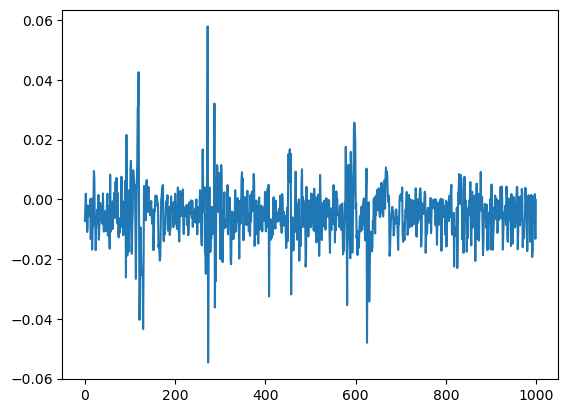

In [8]:
plt.plot(emg)

In [9]:
# Rectify
remg = np.abs(emg)

In [10]:
# Integrate
iremg = np.convolve(remg, np.ones(int(sr)), mode="same")

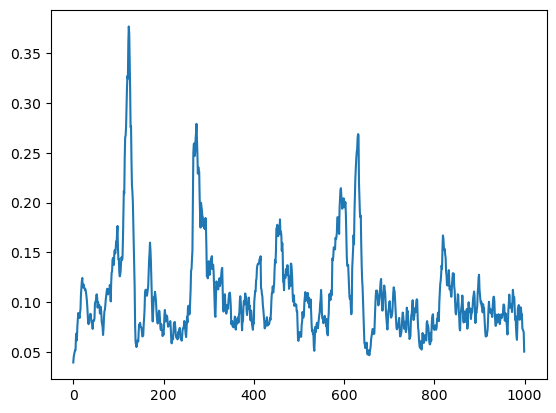

In [11]:
plt.plot(iremg)

In [20]:
window_size = int(sr)*2
threshold = 0.01
tiremg = iremg[:iremg.size - iremg.size%window_size]

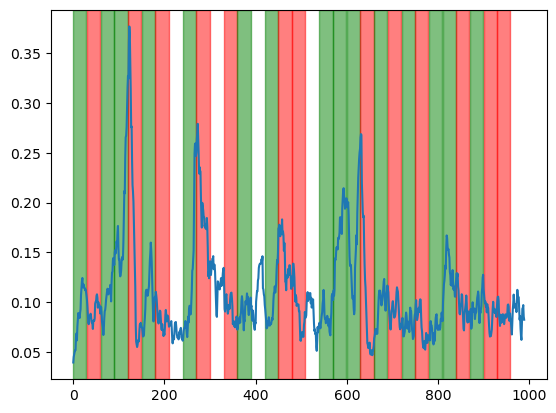

In [21]:
plt.plot(tiremg)

for i, window in enumerate(np.split(tiremg, tiremg.size / window_size)):
    base = i * window_size
    end = (i+1) * (window_size) - 1
    
    grad = np.gradient(window)
    grad = np.sum(grad)
    
    if grad > threshold:
        plt.axvspan(base, end, color="green", alpha=0.5)
    elif grad < -threshold:
        plt.axvspan(base, end, color="red", alpha=0.5)